In [2]:
test_run = True
import os

train_set_path = "/home/jbct/Projects/thesis/db-ocsvm/data/processed/NSL-KDD/minamax_scaler_new/train_set.csv"
validation_set_path = "/home/jbct/Projects/thesis/db-ocsvm/data/processed/NSL-KDD/minamax_scaler_new/validation_set.csv"
test_set_path = "/home/jbct/Projects/thesis/db-ocsvm/data/processed/NSL-KDD/minamax_scaler_new/test_set.csv"

tuning_metric = "f1"  # f1 or accuracy

if test_run:
    use_sample = True
    train_frac = 0.1
    with_storage = False
    trials = 10
else:
    os.makedirs("optuna_storage", exist_ok=True)
    storage_path = "sqlite:///optuna_storage/dbscan_study.db"
    use_sample = False
    train_frac = 1
    with_storage = True
    trials = 100

Test set

In [3]:
import pandas as pd

test_set = pd.read_csv(test_set_path)
print(f"test set count: {test_set.shape[0]:,}")

# Splitting into X and y
X_test = test_set.drop(
    columns=["attack_binary", "attack_categorical", "attack_class"]
).values
y_test = test_set["attack_binary"].values
y_test_class = test_set["attack_class"]

test_set.head(3)

test set count: 11,271


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,attack_binary,attack_categorical,attack_class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,neptune,DoS
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,neptune,DoS
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,neptune,DoS


Validation set

In [4]:
validation_set = pd.read_csv(validation_set_path)
print(f"Validation set count: {validation_set.shape[0]:,}")
print(validation_set["attack_class"].value_counts())

# Splitting into X and y
X_val = test_set.drop(
    columns=["attack_binary", "attack_categorical", "attack_class"]
).values
y_val = test_set["attack_binary"].values
y_val_class = test_set["attack_class"]

validation_set.head(3)

Validation set count: 11,272
attack_class
normal    4856
DoS       3729
R2L       1377
Probe     1210
U2R        100
Name: count, dtype: int64


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,attack_binary,attack_categorical,attack_class
0,0.000099,3.460535e-07,0.000013,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1,guess_passwd,R2L
1,0.000000,3.884730e-06,0.000049,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,normal,normal
2,0.000000,5.670812e-06,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1,smurf,DoS


In [5]:
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd

# First, display the original distribution
print("Before SMOTE:")
print(f"Val set count: {X_val.shape[0]:,}")
before_counts = pd.Series(y_val_class).value_counts()
print(before_counts)

# Apply SMOTE to training data using class labels
sampling_strategy = {
    "DoS": 4000,
    "R2L": 2000,
    "Probe": 2000,
    "U2R": 500,
}
smote = SMOTE(random_state=42, k_neighbors=3, sampling_strategy=sampling_strategy)
X_val_resampled, y_val_resampled = smote.fit_resample(X_val, y_val_class)

# Display the distribution after SMOTE
print("\nAfter SMOTE:")
print(f"Val set count: {X_val_resampled.shape[0]:,}")
after_counts = pd.Series(y_val_resampled).value_counts()
print(after_counts)

# If you need binary labels for further processing, convert back
y_val_resampled = np.where(y_val_resampled == "normal", 1, -1)

Before SMOTE:
Val set count: 11,271
attack_class
normal    4855
DoS       3728
R2L       1377
Probe     1211
U2R        100
Name: count, dtype: int64

After SMOTE:
Val set count: 13,355
attack_class
normal    4855
DoS       4000
Probe     2000
R2L       2000
U2R        500
Name: count, dtype: int64


Train set

In [6]:
train_dataset = pd.read_csv(train_set_path)

if use_sample:
    train_dataset = train_dataset.sample(frac=train_frac, random_state=1)

print(f"train set count: {train_dataset.shape[0]:,}")
train_dataset.head(3)

train set count: 6,734


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
51444,0.0,3.616817e-06,0.002149,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
65414,0.0,5.023357e-07,0.000011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4203,0.0,2.578657e-06,0.000068,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Tuning

In [7]:

from sklearn.svm import OneClassSVM
from sklearn.metrics import f1_score, accuracy_score, precision_score,recall_score
import optuna


def objective(trial):
    nu = trial.suggest_float("nu", 0.01, 0.5)
    gamma = trial.suggest_float("gamma", 0.01, 1.0)

    ocsvm = OneClassSVM(kernel="rbf", nu=nu, gamma=gamma)
    ocsvm.fit(train_dataset.values)

    y_pred_val = ocsvm.predict(X_val_resampled)
    y_pred_test = ocsvm.predict(X_test)
    
    acc_val = accuracy_score(y_val_resampled, y_pred_val)
    f1_val = f1_score(y_val_resampled, y_pred_val, pos_label=-1)
    precision_val = precision_score(y_val_resampled, y_pred_val, pos_label=-1)
    recall_val = recall_score(y_val_resampled, y_pred_val, pos_label=-1)
    print("Validation Results:")
    print(
        {
            "accuracy": f"{acc_val * 100:.2f}",
            "f1": f"{f1_val * 100:.2f}",
            "precision": f"{precision_val * 100:.2f}",
            "recall": f"{recall_val * 100:.2f}",
        }
    )

    print("\nTest Results:")
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test, pos_label=-1)
    precision_test = precision_score(y_test, y_pred_test, pos_label=-1)
    recall_test = recall_score(y_test, y_pred_test, pos_label=-1)
    print(
        {
            "accuracy": f"{acc_test * 100:.2f}",
            "f1": f"{f1_test * 100:.2f}",
            "precision": f"{precision_test * 100:.2f}",
            "recall": f"{recall_test * 100:.2f}",
        }
    )
    
    if tuning_metric == "f1":
        return f1_val
    elif tuning_metric == "accuracy":
        return acc_val
    else:
        raise ValueError("Invalid tuning metric")


if with_storage:
    storage_path = "sqlite:////work/base_ocsvm_study.db"
    study = optuna.create_study(
        direction="maximize",
        storage=storage_path,
        study_name="base_ocsvm_study",
        load_if_exists=True,
    )
    study.optimize(objective, n_trials=trials)
else:
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=trials)


print(f"Best score: {study.best_value:.3f}")
print(f"Best parameters: {study.best_params}")

/home/jbct/Projects/thesis/db-ocsvm/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-03-22 18:36:18,034] A new study created in memory with name: no-name-32bdb885-0c64-482a-9424-b3d35ccf0f8d
[I 2025-03-22 18:36:27,852] Trial 0 finished with value: 0.9272626318711826 and parameters: {'nu': 0.3291158305352625, 'gamma': 0.6340851119013026}. Best is trial 0 with value: 0.9272626318711826.


Validation Results:
{'accuracy': '90.19', 'f1': '92.73', 'precision': '87.80', 'recall': '98.24'}

Test Results:
{'accuracy': '88.44', 'f1': '90.59', 'precision': '84.39', 'recall': '97.77'}


[I 2025-03-22 18:36:37,162] Trial 1 finished with value: 0.9225671048271291 and parameters: {'nu': 0.3498768339923621, 'gamma': 0.5229077210269493}. Best is trial 0 with value: 0.9272626318711826.


Validation Results:
{'accuracy': '89.50', 'f1': '92.26', 'precision': '86.95', 'recall': '98.26'}

Test Results:
{'accuracy': '87.62', 'f1': '90.00', 'precision': '83.34', 'recall': '97.80'}


[I 2025-03-22 18:36:47,894] Trial 2 finished with value: 0.9132834271351292 and parameters: {'nu': 0.39456742362810565, 'gamma': 0.6356364347125164}. Best is trial 0 with value: 0.9272626318711826.


Validation Results:
{'accuracy': '88.12', 'f1': '91.33', 'precision': '85.27', 'recall': '98.32'}

Test Results:
{'accuracy': '85.98', 'f1': '88.83', 'precision': '81.31', 'recall': '97.88'}


[I 2025-03-22 18:36:54,353] Trial 3 finished with value: 0.932809027184134 and parameters: {'nu': 0.21115697272409337, 'gamma': 0.7804329172255038}. Best is trial 3 with value: 0.932809027184134.


Validation Results:
{'accuracy': '91.17', 'f1': '93.28', 'precision': '90.46', 'recall': '96.28'}

Test Results:
{'accuracy': '90.15', 'f1': '91.75', 'precision': '87.73', 'recall': '96.15'}


[I 2025-03-22 18:36:55,667] Trial 4 finished with value: 0.8067946231525447 and parameters: {'nu': 0.04587519441204359, 'gamma': 0.3320134550101753}. Best is trial 3 with value: 0.932809027184134.


Validation Results:
{'accuracy': '78.37', 'f1': '80.68', 'precision': '93.48', 'recall': '70.96'}

Test Results:
{'accuracy': '80.84', 'f1': '81.24', 'precision': '91.74', 'recall': '72.90'}


[I 2025-03-22 18:37:09,682] Trial 5 finished with value: 0.905811623246493 and parameters: {'nu': 0.4345943954016833, 'gamma': 0.7539508174818659}. Best is trial 3 with value: 0.932809027184134.


Validation Results:
{'accuracy': '86.98', 'f1': '90.58', 'precision': '83.93', 'recall': '98.38'}

Test Results:
{'accuracy': '84.62', 'f1': '87.88', 'precision': '79.70', 'recall': '97.94'}


[I 2025-03-22 18:37:15,381] Trial 6 finished with value: 0.8961108787860684 and parameters: {'nu': 0.18229461282308934, 'gamma': 0.28786643646066723}. Best is trial 3 with value: 0.932809027184134.


Validation Results:
{'accuracy': '86.98', 'f1': '89.61', 'precision': '91.03', 'recall': '88.24'}

Test Results:
{'accuracy': '86.99', 'f1': '88.59', 'precision': '88.50', 'recall': '88.67'}


[I 2025-03-22 18:37:31,611] Trial 7 finished with value: 0.8935306373203696 and parameters: {'nu': 0.4911249637046228, 'gamma': 0.38209524787974236}. Best is trial 3 with value: 0.932809027184134.


Validation Results:
{'accuracy': '85.08', 'f1': '89.35', 'precision': '81.84', 'recall': '98.39'}

Test Results:
{'accuracy': '82.38', 'f1': '86.36', 'precision': '77.20', 'recall': '97.97'}


[I 2025-03-22 18:37:32,699] Trial 8 finished with value: 0.8630494243368743 and parameters: {'nu': 0.025605442912918185, 'gamma': 0.6246180094091972}. Best is trial 3 with value: 0.932809027184134.


Validation Results:
{'accuracy': '83.88', 'f1': '86.30', 'precision': '93.95', 'recall': '79.81'}

Test Results:
{'accuracy': '85.32', 'f1': '86.27', 'precision': '92.24', 'recall': '81.02'}


[I 2025-03-22 18:37:44,405] Trial 9 finished with value: 0.925985474302822 and parameters: {'nu': 0.3344428558623772, 'gamma': 0.7468939783221775}. Best is trial 3 with value: 0.932809027184134.


Validation Results:
{'accuracy': '90.00', 'f1': '92.60', 'precision': '87.56', 'recall': '98.25'}

Test Results:
{'accuracy': '88.22', 'f1': '90.43', 'precision': '84.10', 'recall': '97.79'}
Best score: 0.933
Best parameters: {'nu': 0.21115697272409337, 'gamma': 0.7804329172255038}


In [8]:
import optuna
from plotly.io import show

fig = optuna.visualization.plot_optimization_history(study)
show(fig)

In [9]:
fig = optuna.visualization.plot_edf([study])
show(fig)

# Training

In [10]:
from sklearn.svm import OneClassSVM

gamma = study.best_params["gamma"]
nu = study.best_params["nu"]

ocsvm = OneClassSVM(kernel="rbf", gamma=gamma, nu=nu, verbose=True)

ocsvm.fit(train_dataset.values)

[LibSVM].
*
optimization finished, #iter = 1219
obj = 34243.697365, rho = 65.130266
nSV = 1437, nBSV = 1406


OneClassSVM(gamma=0.7804329172255038, nu=0.21115697272409337, verbose=True)

# Testing

Perform prediction

In [11]:
y_pred = ocsvm.predict(X_test)

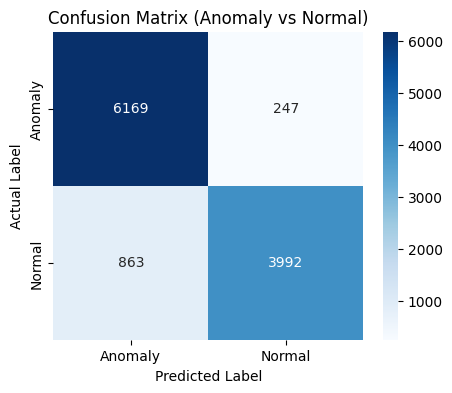

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=[-1, 1])


def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title(title)
    plt.show()


plot_confusion_matrix(cm, ["Anomaly", "Normal"], "Confusion Matrix (Anomaly vs Normal)")

In [13]:
from sklearn.metrics import (
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Anomaly", "Normal"]))

precision = precision_score(y_test, y_pred, pos_label=-1)
recall = recall_score(y_test, y_pred, pos_label=-1)
f1 = f1_score(y_test, y_pred, pos_label=-1)
acc = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {acc}")

Classification Report:
              precision    recall  f1-score   support

     Anomaly       0.88      0.96      0.92      6416
      Normal       0.94      0.82      0.88      4855

    accuracy                           0.90     11271
   macro avg       0.91      0.89      0.90     11271
weighted avg       0.91      0.90      0.90     11271

Precision: 0.8772753128555176
Recall: 0.961502493765586
F1 Score: 0.9174598453301607
Accuracy: 0.9015171679531541


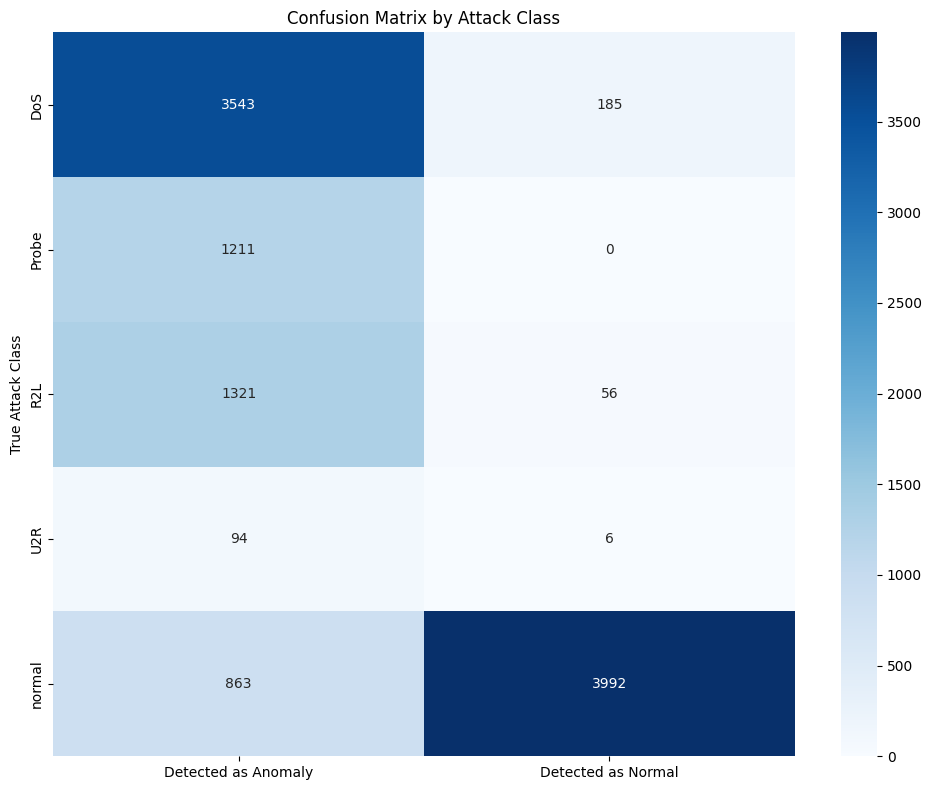

In [14]:
import numpy as np


def create_multiclass_cm(y_true_class, y_pred_binary):
    """
    Create a confusion matrix showing how each attack class was classified.

    For attack classes (DoS, Probe, R2L, U2R), correct detection is when y_pred = -1 (anomaly)
    For normal class, correct detection is when y_pred = 1 (normal)
    """
    classes = np.unique(y_true_class)
    cm = np.zeros((len(classes), 2))

    for i, cls in enumerate(classes):
        # Get predictions for this class
        cls_indices = y_true_class == cls
        preds = y_pred_binary[cls_indices]

        # Count correct and incorrect predictions
        if cls == "normal":
            cm[i, 0] = np.sum(preds == -1)  # incorrectly detected as anomaly
            cm[i, 1] = np.sum(preds == 1)  # correctly detected as normal
        else:
            cm[i, 0] = np.sum(preds == -1)  # correctly detected as anomaly
            cm[i, 1] = np.sum(preds == 1)  # incorrectly detected as normal

    return cm, classes


# Create and plot the multi-class confusion matrix
cm_multi, classes = create_multiclass_cm(y_test_class, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_multi,
    annot=True,
    fmt="g",
    cmap="Blues",
    xticklabels=["Detected as Anomaly", "Detected as Normal"],
    yticklabels=classes,
)
plt.ylabel("True Attack Class")
plt.title("Confusion Matrix by Attack Class")
plt.tight_layout()
plt.show()

In [15]:
# Calculate detection rates for each class
print("Detection rates by class:")
class_metrics = {}
for cls in np.unique(y_test_class):
    # Get indices for this class
    class_indices = y_test_class == cls

    # True values and predictions for this class
    y_true_cls = y_test[class_indices]
    y_pred_cls = y_pred[class_indices]

    # Calculate metrics
    if cls == "Normal":
        # For normal class, we want to detect 1 (normal)
        correct = np.sum((y_pred_cls == 1))
        precision = precision_score(
            y_true_cls, y_pred_cls, pos_label=1, zero_division=0
        )
        recall = recall_score(y_true_cls, y_pred_cls, pos_label=1, zero_division=0)
    else:
        # For attack classes, we want to detect -1 (anomaly)
        correct = np.sum((y_pred_cls == -1))
        precision = precision_score(
            y_true_cls, y_pred_cls, pos_label=-1, zero_division=0
        )
        recall = recall_score(y_true_cls, y_pred_cls, pos_label=-1, zero_division=0)

    total = len(y_pred_cls)
    detection_rate = correct / total
    f1 = f1_score(
        y_true_cls, y_pred_cls, pos_label=-1 if cls != "Normal" else 1, zero_division=0
    )

    class_metrics[cls] = {
        "detection_rate": detection_rate,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "count": total,
        "correctly_detected": correct,
    }

    print(f"{cls}: {detection_rate:.4f} ({correct}/{total})")

Detection rates by class:
DoS: 0.9504 (3543/3728)
Probe: 1.0000 (1211/1211)
R2L: 0.9593 (1321/1377)
U2R: 0.9400 (94/100)
normal: 0.1778 (863/4855)
